# 2.4 생성된 답변을 여러번 검증하는 Self-RAG

- [Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection](https://arxiv.org/abs/2310.11511)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
![self-rag](https://i.imgur.com/X11ND6N.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

앞에 작업한 것과 동일한 코드 정의

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [3]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [6]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model="gpt-4o", max_completion_tokens=100)
# 뒤에 할루시네이션 체크를 잘되게 하기 위해 max토큰 길이 조정


def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state["context"]
    query = state["query"]

    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = generate_prompt | generate_llm

    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({"question": query, "context": context})

    # 생성된 답변을 반환합니다
    return {"answer": response.content}

`retrieve` 노드는 앞에 작업한 것을 수정한다.   
    - 문서와 관련이 없다면 질문에 답변할 수 없다고 판단하고 마무리   
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성

**(중요)**   
그런데 관련이 없을 때 END를 리턴하면 에러가 발생함.   
END는 노드가 아니어서 선택할 수 없기 때문이다.   
따라서 relevant와 irrelevant를 리턴하는 함수를 만들어서 사용한다.

In [7]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState) -> Literal["relevant", "irrelevant"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state["query"]
    context = state["context"]

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})

    if response["Score"] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return "relevant"

    return "irrelevant"

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(
    f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
"""
)


def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

### 추가 노드 개발

답변이 `retrieve` 노드에서 추출된 문서와 관련이 있는지 판단하는 노드
- 문서와 관련이 없다면 `generate` 노드로 이동해서 답변을 다시 생성
- 문서와 관련이 있다면 `check_helpfulness` 노드로 이동해서 답변이 도움이 되는지 판단

In [9]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template(
    """
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
"""
)

hallucination_llm = ChatOpenAI(model="gpt-4o", temperature=0)

- langchain hub를 참고함   
- https://smith.langchain.com/hub/rlm/rag-answer-hallucination?organizationId=a0ac76fa-c299-507d-8cdf-5fd4bd50925c

In [10]:
def check_hallucination(
    state: AgentState,
) -> Literal["hallucinated", "not hallucinated"]:
    answer = state["answer"]
    context = state["context"]
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke(
        {"student_answer": answer, "documents": context}
    )

    return response

테스트 해보기

In [11]:
query = "연봉 5천만원인 거주자의 소득세는 얼마인가요?"
context = retriever.invoke(query)
print("document")
for document in context:
    print(document.page_content)
print(context)

generate_state = {"query": query, "context": context}
answer = generate(generate_state)
print(f"answer: {answer}")

hallucination_state = {"answer": answer, "context": context}
check_hallucination(hallucination_state)

document
| 종합소득         | 세 율                                  |
|------------------|---------------------------------------|
| 1,400만원 이하   | 과세표준의 6세례셋트                      |
| 1,400만원 초과   | 84만원 + (1,400만원을 초과하는 금액의 15%)  |
| 5,000만원 이하   | 624만원 + (5,000만원을 초과하는 금액의 24%)  |
| 8,800만원 이하   | 1,536만원 + (8,800만원을 초과하는 금액의 35%) |
| 1억5천만원 이하  | 3,706만원 + (1억5천만원을 초과하는 금액의 38%) |
| 3억 이하         | 9,460만원 + (3억을 초과하는 금액의 40%)      |
| 5억 이하         | 1억7,406만원 + (5억을 초과하는 금액의 42%)   |
| 10억 이하        | 3억8,406만원 + (10억을 초과하는 금액의 45%)  |
법제처 35 
국가법령정보센터
소득세법
② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다.
<개정> 2013. 1. 1, 2014. 12. 23.
1. 해당 사업기간의 퇴직소득세표준(제1항의 세율을 적용하여 계산한 금액
2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액
3. 삭제<2014. 12. 23.>
[전문개정 2009. 12. 31.]
제2장 세액공제
<개정> 2009. 12. 31.
제56조(배당세액공제)
① 거주자의 종합소득금액에 제17조제3항 각 호의 부분 단서가 적용되는 배당소득액이 합산되어 있는 경우에는 같은 항 각 호 외의 부분 단서에 따라 해당 과세기간의 총수입금액에 대한 금액에 해당하는 세액을 종합소득 산출세액에서 공제한다.
<개정> 2009. 12. 31.
② 제1항에 따른 공제율을 "배당세액공제"

'hallucinated'

**(중요)**  
잘 안되면 generate 토큰 길이, temperature, 프롬프트 조정해볼 것

-----

생성된 답변이 사용자의 질문과 관련이 있는지 판단하는 노드
- 질문과 관련이 있다면 사용자에게 답변을 리턴합니다
- 질문과 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
    - `rewrite` 후 다시 `retrieve` 합니다

섹션 3에 나오는 것처럼 `check_helpfulness` node를 생성하지 않고 `check_helpfulness_grader`만 추가해서 `conditional_edge`로 사용할 수도 있음

In [12]:
from langchain import hub

# LangChain 허브에서 유용성 프롬프트를 가져옵니다
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

In [13]:
print(helpfulness_prompt.messages[0].prompt.template)

You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Score:
A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset.


질문과 답변을 비교하는 노드 정의

In [14]:
def check_helpfulness_grader(state: AgentState) -> str:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.

    Args:
        state (AgentState): 사용자의 질문과 생성된 답변을 포함한 에이전트의 현재 state.

    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다.
    """
    # state에서 질문과 답변을 추출합니다
    query = state["query"]
    answer = state["answer"]

    # 답변의 유용성을 평가하기 위한 체인을 생성합니다
    helpfulness_chain = helpfulness_prompt | llm

    # 질문과 답변으로 체인을 호출합니다
    response = helpfulness_chain.invoke({"question": query, "student_answer": answer})

    # 점수가 1이면 'helpful'을 반환하고, 그렇지 않으면 'unhelpful'을 반환합니다
    if response["Score"] == 1:
        return "helpful"

    return "unhelpful"


In [15]:
query = "연봉 5천만원인 거주자의 소득세는 얼마인가요?"
context = retriever.invoke(query)

generate_state = {"query": query, "context": context}
answer = generate(generate_state)

helpfulness_state = {"query": query, "answer": answer}
check_helpfulness_grader(helpfulness_state)

'helpful'

node -> conditional_edge 구성을 위해 필요

In [16]:
def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수입니다.
    graph에서 conditional_edge를 연속으로 사용하지 않고 node를 추가해
    가독성을 높이기 위해 사용합니다

    Args:
        state (AgentState): 에이전트의 현재 state.

    Returns:
        AgentState: 변경되지 않은 state를 반환합니다.
    """
    # 이 함수는 현재 아무 작업도 수행하지 않으며 state를 그대로 반환합니다
    return state

### 연결 작업
`node`를 추가하고 `edge`로 연결

![self-rag](https://i.imgur.com/X11ND6N.png)

노드 정의

In [17]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_helpfulness", check_helpfulness)

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve", check_doc_relevance, {"relevant": "generate", "irrelevant": END}
)
graph_builder.add_conditional_edges(
    "generate",
    check_hallucination,
    {"not hallucinated": "check_helpfulness", "hallucinated": "generate"},
)

graph_builder.add_conditional_edges( # 중요!!!
    "check_helpfulness",
    check_helpfulness_grader,
    {"helpful": END, "unhelpful": "rewrite"},
)
graph_builder.add_edge("rewrite", "retrieve")

In [19]:
graph = graph_builder.compile()

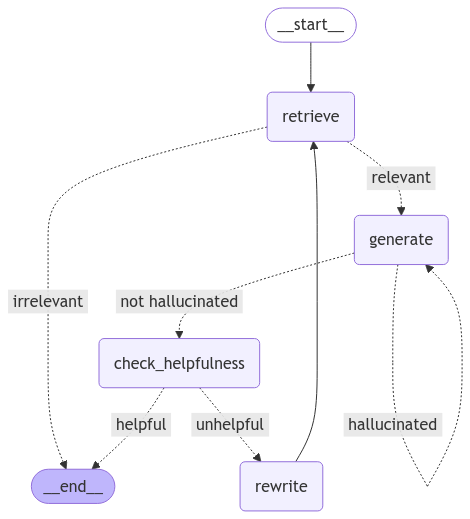

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
initial_state = {"query": "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='| 종합소득         | 세 율                                  |\n|------------------|---------------------------------------|\n| 1,400만원 이하   | 과세표준의 6세례셋트                      |\n| 1,400만원 초과   | 84만원 + (1,400만원을 초과하는 금액의 15%)  |\n| 5,000만원 이하   | 624만원 + (5,000만원을 초과하는 금액의 24%)  |\n| 8,800만원 이하   | 1,536만원 + (8,800만원을 초과하는 금액의 35%) |\n| 1억5천만원 이하  | 3,706만원 + (1억5천만원을 초과하는 금액의 38%) |\n| 3억 이하         | 9,460만원 + (3억을 초과하는 금액의 40%)      |\n| 5억 이하         | 1억7,406만원 + (5억을 초과하는 금액의 42%)   |\n| 10억 이하        | 3억8,406만원 + (10억을 초과하는 금액의 45%)  |\n법제처 35 \n국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다.\n<개정> 2013. 1. 1, 2014. 12. 23.\n1. 해당 사업기간의 퇴직소득세표준(제1항의 세율을 적용하여 계산한 금액\n2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n3. 삭제<2014. 12. 23.>\n[전문개정 2009. 12. 31.]\n제2장 세액공제\n<개정> 2009. 12. 31.\n제56조(배당세액공제)\n① 거주자의 종합소득금액에 제17조제3항 각 호의

In [21]:
initial_state = {"query": "배가 고파요"}
graph.invoke(initial_state)

{'query': '배가 고파요',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='삭제<2012. 1. 1.>\n삭제<2012. 1. 1.>'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='소득세법\n제12조(주택임대소득 미등록 가산세)\n① 주택임대소득이 있는 사업자가 제168조제1항 및 제3항에 따라 ‘부가가치세’, 제83조제1항 본문에 따른 기간까지 등록을 신청하지 아니한 경우에는 사업 개시일부터 등록을 신청하는 날이 속하는 달의 주택임대소득의 1천분의 2를 가산세로 하여 과세기간의 종합소득 결정시기에 더하여 납부하여야 한다.\n\xa0 - [본조순서 2019. 12. 31]\n제13조(특정외국법인의 유보소득 계상 명세서 제출 불성실 가산세)\n① ‘국제조세조정에 관한 법률’, 제34조제3호 에 따른 특정국법인의 유보소득 계상 명세서(이하 ‘명세서’라 한다)와 같은 조에 따라 제출하여야 하는 가산세는 다음 각 호의 어느 하나에 해당하는 경우에는 해당 특정국법인의 배당 가능 유보소득의 1분본의 5를 가산세로 하여 과세기간의 종합소득 결정시기에 더하여 납부하여야 한다.\n1. 명세서가 적시에 제출되지 아니한 경우\n2. 제출한 명세서가 전부 또는 일부를 적시 아니하는 경우\n\xa0 - [개정 2020. 12. 29]\n제14조(업무용부동산 관련 비용 명세서 제출 불성실 가산세)\n① 제33조의2제1항부터 제3항까지의 규정에 따라 업무용부동산 관련 비용 등을 포함하여 신고한 세무기장자(이하 ‘사업자’라 한다)와 같은 조에 따라 업무용부동산의 구분에 따른 원액을 가산세로 하여 과세기간의 종합소득 결정시기에 대하여 납부하여야 한다.\n1. 명세서가 제출되지 아니한 경우: 해당 복식부기의무자에게 제70조의2에 따른 신용카드및업무용품 관련 비용 등으로 필요금액에 산입